# <font color='royalblue'>  Latency to reach the choice point during test runs analysis 
### In this notebook I will analyze the latency until choice point during test runs and compare within and across each experimental group and stimulation condition
### If the cingulate cortex is involved in computations leading to the expression of choice, we hypothesize that the latency to choice point in the test illumination condition will be higher in NpHR+ rats when compared to the same condition in NPHR- rats or Non-illuminated periods in both. This increased latency could be a behavioral output of delayed or perturbed choice.
    
### We will also consider the sample illuminated test runs in this analysis, in order to understand whether illuminating the sample run in NpHR+ rats could also lead to latency changes during the following test run, when compared with the Non-illuminated test runs or sample illumination in the NpHR- rats.
    

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='royalblue'> Read the data (test runs below 15 seconds)

In [27]:
file_path = "E:\POSITION DATA\PRE PROCESSED/below15_runs.csv"
below15 = pd.read_csv(file_path)

In [28]:
below15.head()

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,2.989453,4.061312,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971
3,2019-08-08T12_41_07,NPHR1,18.0,1151.446016,T,0,1.0,NPHR,1153.832614,1154.563149,2.386598,3.117133,0.730534
4,2019-08-08T12_41_07,NPHR1,22.0,1375.846490,T,3,1.0,NPHR,1378.606669,1379.300582,2.760179,3.454093,0.693914


### <font color='royalblue'>Remove pre-illuminated and sample illuminated trials

In [34]:
below15 = below15[(below15['stim_condition']==0)|(below15['stim_condition']==3)]
below15['stim_condition'].unique()

array([3, 0], dtype=int64)

In [45]:
counts=below15.groupby(['group','stim_condition']).count()['session']
counts

group  stim_condition
CTRL   0                  954
       3                  937
NPHR   0                 1196
       3                 1164
Name: session, dtype: int64

# <font color='royalblue'> Latency to choice point distributions 

### Histograms and cumulative distributions within group

<Figure size 1800x1200 with 0 Axes>

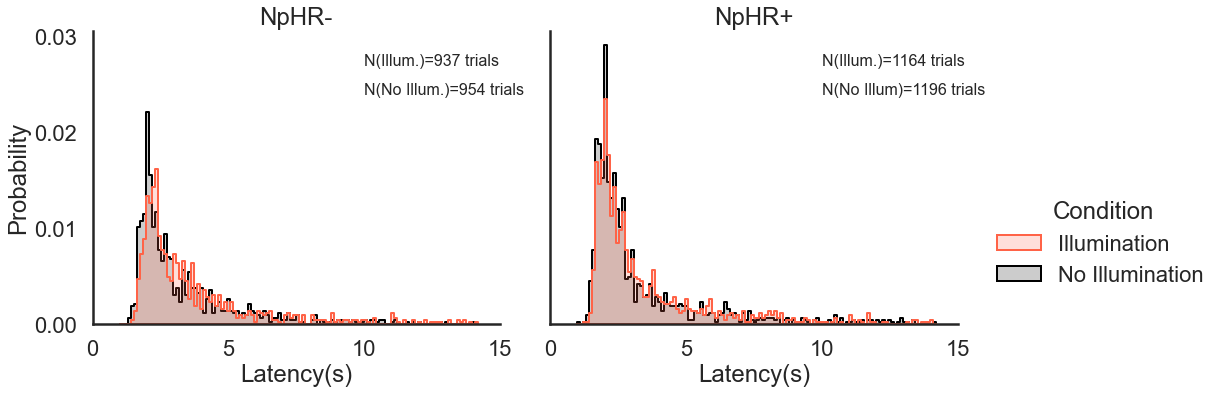

In [47]:
sns.set(style='white', context='poster')
plt.figure(dpi=300)

#Plot histograms (8 bins per seconds)
g = sns.displot(kind='hist', data=below15, col='group', 
                x='latency_to_cp_entry', stat='probability', 
                hue=below15['stim_condition'].map({0:'No Illumination ', 3:'Illumination'}), 
                col_order=['CTRL', 'NPHR'], element='step', palette=['tomato','black'], 
                bins=120, alpha=.2, height=6, linewidth=2, aspect=1.2)

# subplot specifications
axes = g.axes.flatten()

axes[0].set(title="NpHR-", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].text(10,.027,'N(Illum.)='+str(counts.loc['CTRL',3])+' trials', fontsize=16)
axes[0].text(10,.024,'N(No Illum.)='+str(counts.loc['CTRL',0])+' trials', fontsize=16)
axes[1].text(10,.027,'N(Illum.)='+str(counts.loc['NPHR',3])+' trials', fontsize=16)
axes[1].text(10,.024,'N(No Illum)='+str(counts.loc['NPHR',0])+' trials', fontsize=16)

#Legend 
g._legend.set(bbox_to_anchor=(.97,.35), title='Condition')
g.tight_layout()
sns.despine()

<Figure size 1800x1200 with 0 Axes>

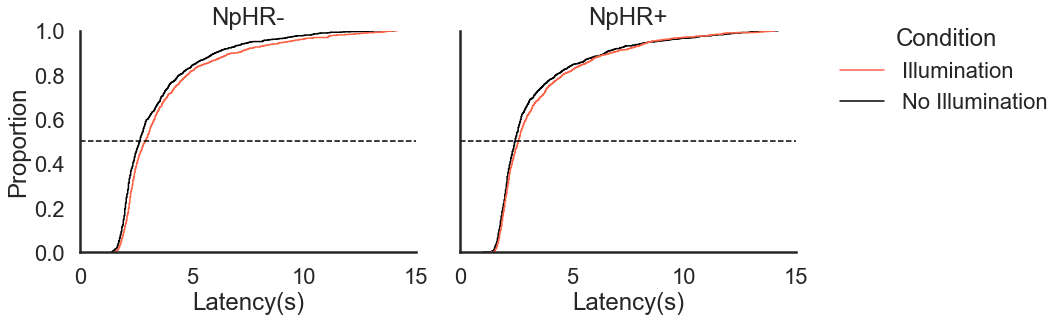

In [49]:
sns.set(style='white', context='poster')
plt.figure(dpi=300)

g = sns.displot(kind='ecdf', data=below15, col='group', 
            x='latency_to_cp_entry', stat='proportion',
            hue=below15['stim_condition'].map({0:'No Illumination ', 3:'Illumination'}),
            col_order=['CTRL','NPHR'], palette=['tomato','black'], height=5, aspect=1.2, linewidth=1.5)
# subplot specs
axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

axes[1].set(title="NpHR+", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

#Legend 
g._legend.set(bbox_to_anchor=(.98,.7), title='Condition')
g.tight_layout()
sns.despine()

### Inference testing on latency to choice point distributions within group

##### The data is clearly not normally distributed, so I will use a non-parametric test (medians). I will be using the Mann-Whitney test to compare the medians of the distributions (has they have a similar shape):
##### H0: the medians of the two groups are equal vs. HA: the medians of the two groups are not equal (two-sided)
##### The data set is dependent - same individuals in two conditions of illumination -  although not paired. For this reason I will not use the Wilcoxon Rank Sum Test. 

In [55]:
# Test No vs. Illumnation in the NpHR- group
ctrl_no_illum = below15[(below15['stim_condition']==0) & (below15['group']=='CTRL')]
ctrl_illum = below15[(below15['stim_condition']==3) & (below15['group']=='CTRL')]
u, p = mannwhitneyu(x=ctrl_no_illum['latency_to_cp_entry'], y=ctrl_illum['latency_to_cp_entry'])
print(u, p)

397301.5 1.4450818907858461e-05


In [56]:
# Test No vs. Illumnation in the NpHR+ group
nphr_no_illum = below15[(below15['stim_condition']==0) & (below15['group']=='NPHR')]
nphr_illum = below15[(below15['stim_condition']==3) & (below15['group']=='NPHR')]
u, p = mannwhitneyu(x=nphr_no_illum['latency_to_cp_entry'], y=nphr_illum['latency_to_cp_entry'])
print(u, p)

647980.0 0.0018314537390134555


### Histograms and cumulative distributions within condition

<Figure size 1800x1200 with 0 Axes>

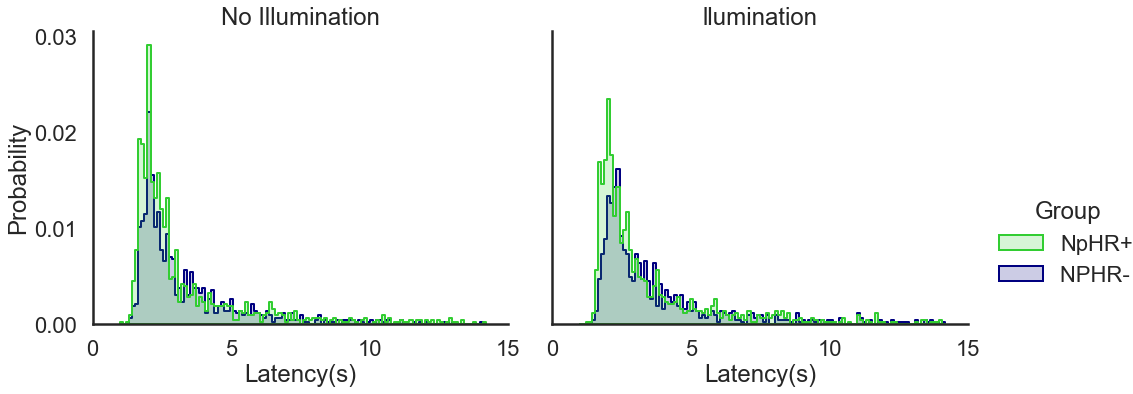

In [58]:
sns.set(style='white', context='poster')
plt.figure(dpi=300)

# Plot histogram ( 8 bins per second)
g = sns.displot(kind='hist', data=below15, col='stim_condition', 
                x='latency_to_cp_entry', stat='probability', 
                hue=below15['group'].map({'CTRL':'NPHR- ', 'NPHR':'NpHR+'}), 
                col_order=[0, 3], element='step', palette=['limegreen','navy'], 
                bins=120, alpha=.2, height=6, linewidth=2, aspect=1.2)

# subplot specifications
g.set(xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))

axes = g.axes.flatten()
axes[0].set(title="No Illumination")
axes[1].set(title="llumination")
#axes[0].text(10,.027,'N(NPHR+)='+str(counts.loc['NPHR',3])+' trials', fontsize=16)
#axes[0].text(10,.024,'N(NPHR-)='+str(counts.loc['CTRL',3])+' trials', fontsize=16)
#axes[1].text(10,.027,'N(NPHR+.)='+str(counts.loc['NPHR','0'])+' trials', fontsize=16)
#axes[1].text(10,.024,'N(NPHR-)='+str(counts.loc['CTRL','0'])+' trials', fontsize=16)

#Legend 
g._legend.set(bbox_to_anchor=(.97,.35), title='Group')
g.tight_layout()
sns.despine()

<Figure size 1800x1200 with 0 Axes>

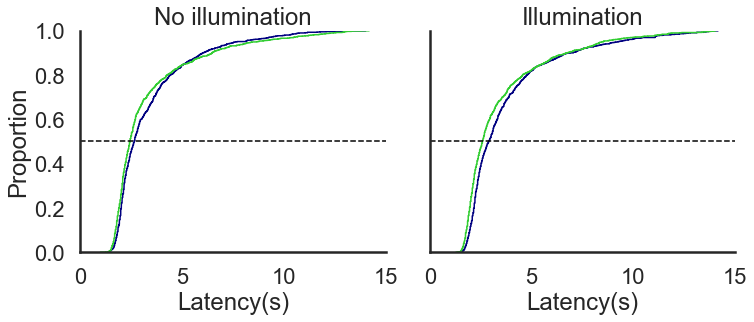

In [59]:
sns.set(style='white', context='poster')
plt.figure(dpi=300)

g = sns.displot(kind='ecdf', data=below15, col='stim_condition', 
            x='latency_to_cp_entry', stat='proportion',
            hue=below15['group'].map({'CTRL':'NpHR- ', 'NPHR':'NpHR+'}),
            col_order=[0,3], palette=['limegreen','navy'], height=5, aspect=1.1, linewidth=1.5, legend=False)
# subplot specs
axes = g.axes.flatten()
axes[0].set(title="No illumination", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

axes[1].set(title="Illumination", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

g.tight_layout()
sns.despine()

###  Inference testing on latency to choice point distributions within conditions

In [62]:
# Test NpHR+ and NpHR- in the illumination condition
ctrl_illum = below15[(below15['stim_condition']==0) & (below15['group']=='CTRL')]
nphr_illum = below15[(below15['stim_condition']==0) & (below15['group']=='NPHR')]
u, p = mannwhitneyu(x=ctrl_illum['latency_to_cp_entry'], y=nphr_illum['latency_to_cp_entry'])
print('No illumination: '+str(u)+', '+str(p))

No illumination: 517494.0, 0.00010534787962922157


In [63]:
# Test NpHR+ and NpHR- in the illumination condition
ctrl_illum = below15[(below15['stim_condition']==3) & (below15['group']=='CTRL')]
nphr_illum = below15[(below15['stim_condition']==3) & (below15['group']=='NPHR')]
u, p = mannwhitneyu(x=ctrl_illum['latency_to_cp_entry'], y=nphr_illum['latency_to_cp_entry'])
print('Illumination: '+str(u)+', '+str(p))

Illumination: 473916.5, 1.190077759281088e-07


## <font color='royalblue'> Latency to choice point across sessions

In [95]:
# Add session numbers to each session timestamp
def add_session_nr(group):
    
    session_list = np.sort(group['session'].unique())
    i=1  
    for session in session_list:
        group.loc[group['session']==session,'session_nr']=i
        i+=1
    return group

below15= below15.groupby(['group', 'rat']).apply(add_session_nr).reset_index(drop=True)

In [96]:
# Calculate the median latencies across sessions
medians = below15.groupby(['group','stim_condition','rat','session_nr'])['latency_to_cp_entry'].apply(np.median)
medians = medians.reset_index()

#Remove two extra sessions from NPHR6
medians = medians[medians['session_nr'].between(0,15)]

### Median latency across sessions within each group

<Figure size 1800x1200 with 0 Axes>

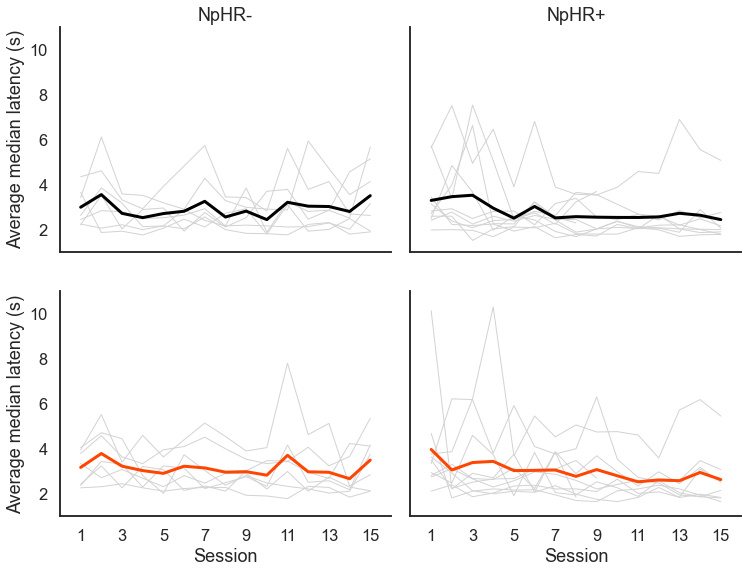

In [112]:
plt.figure(dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=medians, col='group', row='stim_condition',
                x='session_nr', y='latency_to_cp_entry', hue='rat',
                height=4, aspect=1.3, linewidth=1,palette=['lightgray']*17)

for group, ax in g.axes_dict.items():
    if 0 in group:
        color='black'
    else:
        color='orangered'
        
    data = medians[(medians['group']==group[1]) & (medians['stim_condition']==group[0])]
    sns.lineplot(data=data, x='session_nr', y='latency_to_cp_entry',
                 ci=None, color=color, linewidth=3, ax=ax, legend=False)
    
g.set(ylabel= 'Average median latency (s)', xlabel='Session', xlim=[0,16], ylim=[1,11],
      xticks=range(1,16,2), xticklabels=range(1,16,2))
g._legend.remove()
axes = g.axes.flatten()
axes[0].set(title="NpHR-")
axes[1].set(title="NpHR+")
axes[2].set(title="")
axes[3].set(title="")
sns.despine()

### Median latency difference across sessions in each group

In [98]:
medians_illumination = medians[medians['stim_condition']==3].reset_index(drop=True).sort_index()
medians_no_illumination = medians[medians['stim_condition']==0].reset_index(drop=True).sort_index()
medians_illumination['median_diff'] = medians_no_illumination['latency_to_cp_entry'] - medians_illumination['latency_to_cp_entry']
medians_diff = medians_illumination.drop(['latency_to_cp_entry'], axis=1)

<Figure size 1800x1200 with 0 Axes>

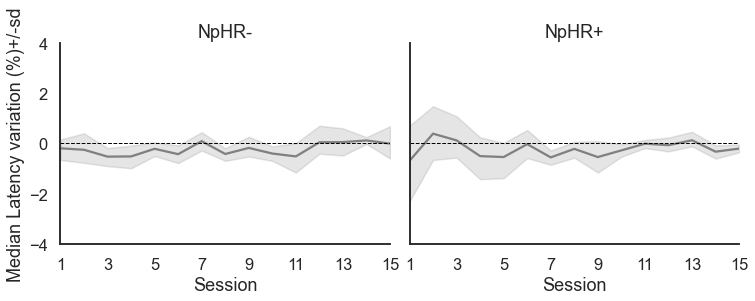

In [110]:
plt.figure(dpi=300)
sns.set(style="white", context='talk')

g = sns.relplot(
    data=medians_diff, kind='line', col='group', x='session_nr', y='median_diff', estimator=np.mean,
    col_order=['CTRL','NPHR'], height=4, aspect=1.3, color='gray', legend=False
)
g.set(xlabel='Session', ylabel='Median Latency variation (%)+/-sd', xticks=range(1,16,2),
      xticklabels=range(1,16,2), xlim=[1,15], ylim=[-4,4])

ax=g.axes.flatten()
ax[0].axhline(linewidth=1, color='black', linestyle='dashed')
ax[1].axhline(linewidth=1, color='black', linestyle='dashed')
ax[0].set(title='NpHR-')
ax[1].set(title='NpHR+')
sns.despine()

### Median Latency subdivided by group, for each condition

<Figure size 1800x1200 with 0 Axes>

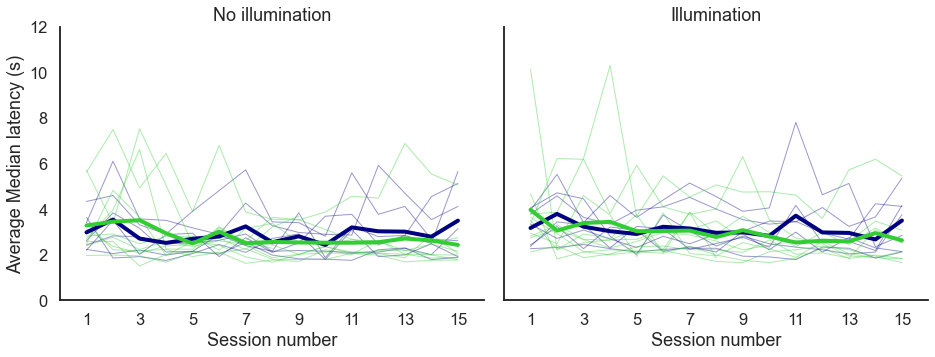

In [133]:
plt.figure(dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=medians, col='stim_condition', x='session_nr', 
                y='latency_to_cp_entry', hue='rat', col_order=[0,3], linewidth=1, 
                height=5, aspect=1.3, palette=['navy']*7+['limegreen']*10, alpha=.4)

for group, ax in g.axes_dict.items():
    data = medians[medians['stim_condition']==group]
    sns.lineplot(data=data, x='session_nr', y='latency_to_cp_entry', hue='group',
                 ci=None, palette=['navy','limegreen'], linewidth=4, ax=ax, legend=False)
     
g.set(ylabel= 'Average Median latency (s)', xlabel='Session number', xlim=[0,16],
      xticks=range(1,16,2), xticklabels=range(1,16,2), ylim=[0,12])
g._legend.remove()
axes = g.axes.flatten()
axes[0].set(title="No illumination")
axes[1].set(title="Illumination")
sns.despine()

In [134]:
def get_first_and_last_n_sessions(df, n):
   
    df.loc[:, 'first_last']=np.nan
    df.loc[df['session_nr'].between(1,n), 'first_last']=0
    df.loc[df['session_nr'].between(16-n, 15), 'first_last']=1
   
    return df

In [135]:
below15 = get_first_and_last_n_sessions(below15, 5)

### Comparing first and last n session distributions in each condition - illumination

In [137]:
illumination = below15[below15['stim_condition']==3]
illumination.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp,session_nr,first_last
0,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917,1.0,0.0
1,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971,1.0,0.0
3,2019-08-08T12_41_07,NPHR1,22.0,1375.846490,T,3,1.0,NPHR,1378.606669,1379.300582,2.760179,3.454093,0.693914,1.0,0.0


In [143]:
illumination_medians = illumination.groupby(['group','first_last', 'rat', 'session'])['latency_to_cp_entry'].apply(np.median).reset_index()
illumination_medians.groupby(['group', 'first_last']).count()

rat  session  latency_to_cp_entry
group first_last                                   
CTRL  0.0          35       35                   35
      1.0          35       35                   35
NPHR  0.0          50       50                   50
      1.0          40       40                   40

<Figure size 1800x1200 with 0 Axes>

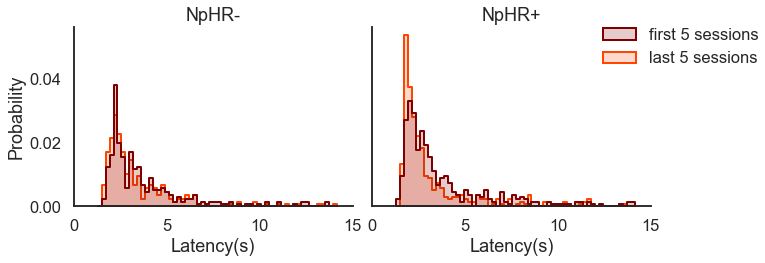

In [140]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)

g = sns.displot(kind='hist', data=illumination, col='group', x='latency_to_cp_entry',
            stat='probability', hue=illumination['first_last'].map({0:'first 5 sessions ', 1:'last 5 sessions '}), 
            col_order=['CTRL', 'NPHR'], element='step', palette=['maroon','orangered'], 
            bins=60, alpha=.2, height=4, aspect=1.2, linewidth=2)

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
g._legend.set(bbox_to_anchor=(.9,.75), title='')
sns.despine()

<Figure size 1800x1200 with 0 Axes>

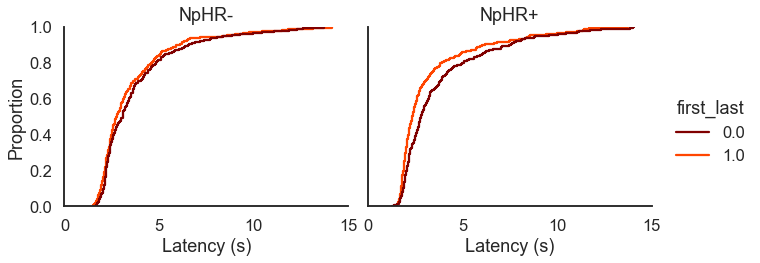

In [144]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
g = sns.displot(kind='ecdf', data=illumination, col='group' , x='latency_to_cp_entry',
            stat='proportion', hue='first_last', col_order=['CTRL', 'NPHR'], palette=['maroon','orangered'],
            height=4, aspect=1.2)

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
sns.despine()

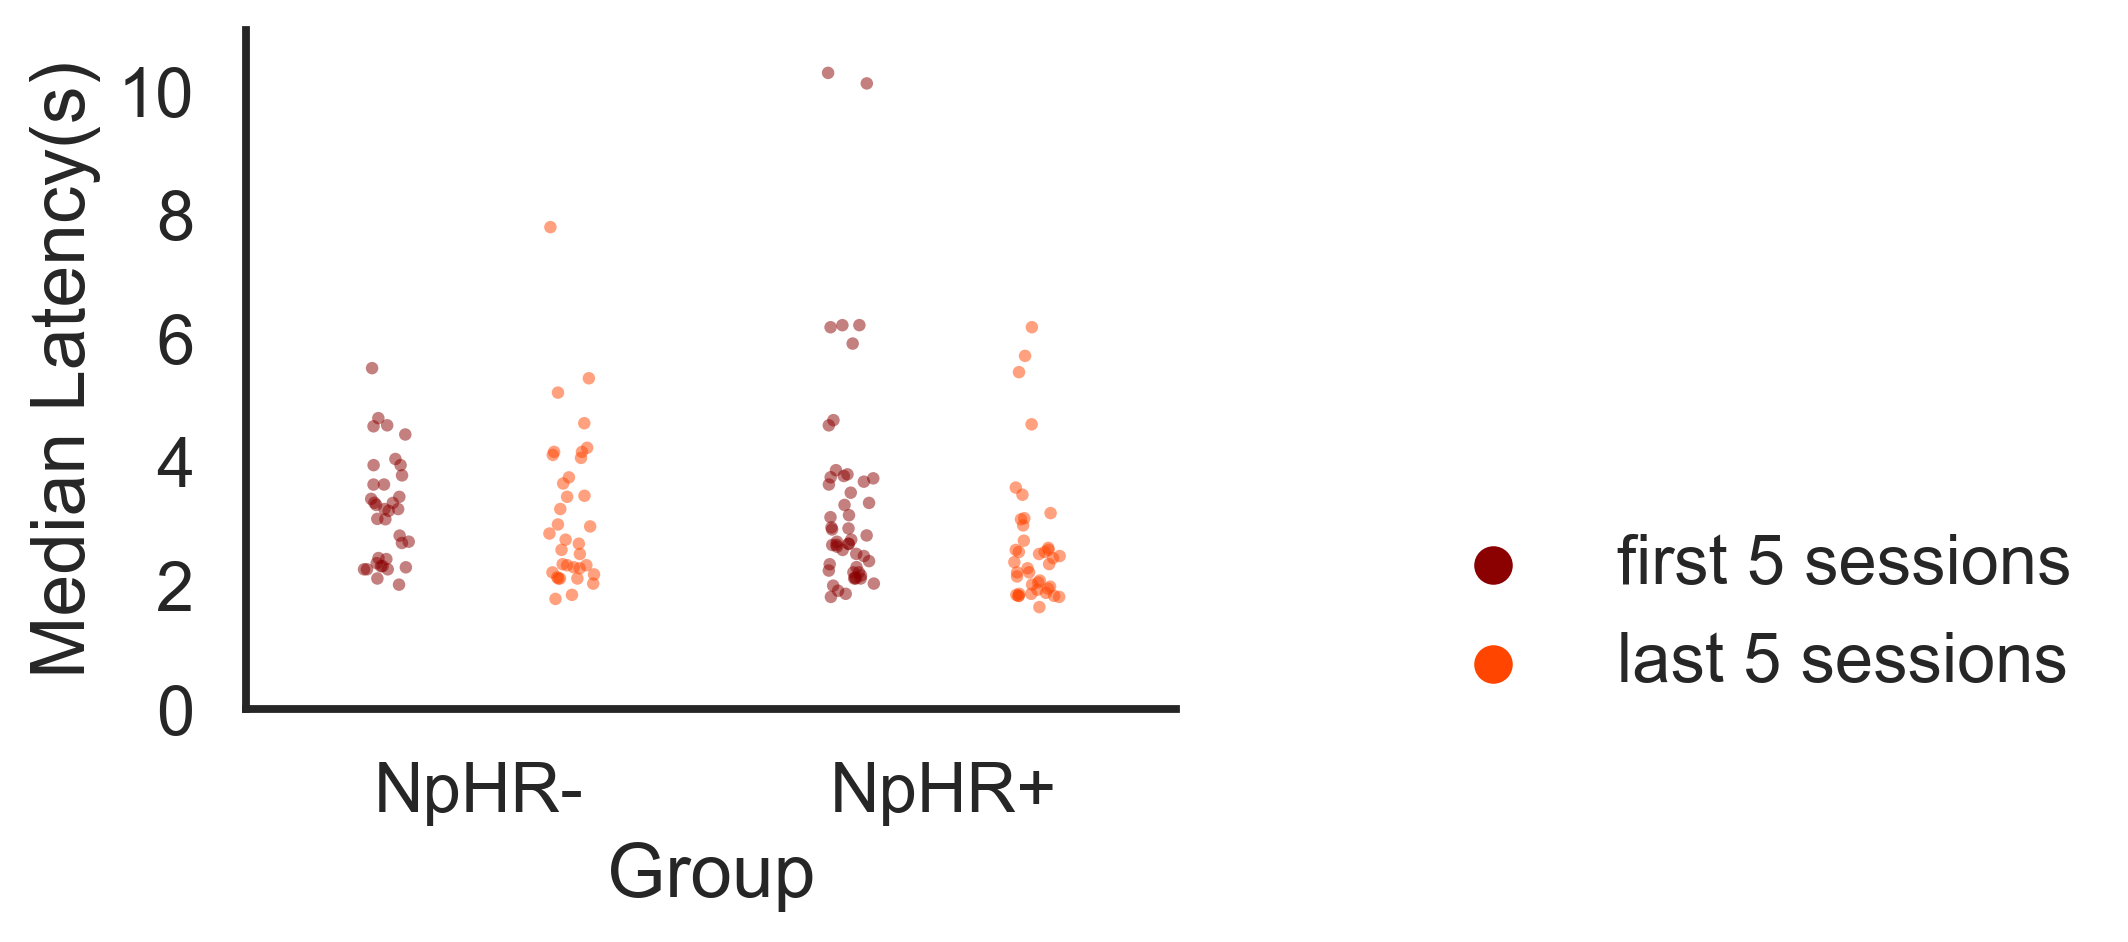

In [151]:
sns.set(style='white', context='talk')
plt.figure(figsize=(4,3), dpi=300)
g = sns.stripplot(
                data=illumination_medians, x='group', y='latency_to_cp_entry', 
                hue=illumination_medians['first_last'].map({0:'first 5 sessions', 1:'last 5 sessions'}),
                palette=['darkred','orangered'], dodge=True, s=3, alpha=.5)

g.set(xlabel='Group', ylabel='Median Latency(s)', xticks=[0,1], 
      xticklabels=['NpHR-', 'NpHR+'], ylim=[0,11], yticks=range(0,11,2), yticklabels=range(0,11,2))
plt.legend(bbox_to_anchor=(1.2,.35), title='', frameon=False)
sns.despine()

### Inference testing comparing distributions in first and last sessions

In [155]:
ctrl_illum_first = illumination[(illumination['group']=='CTRL') & (illumination['first_last']==0)]
ctrl_illum_last = illumination[(illumination['group']=='CTRL') & (illumination['first_last']==1)]
u, p = mannwhitneyu(x=ctrl_illum_first['latency_to_cp_entry'], y=ctrl_illum_last['latency_to_cp_entry'])
print('NpHR-, Illumination, first vs. last: '+str(u)+', '+str(p))

NpHR-, Illumination, first vs. last: 43009.0, 0.031324405229019685


In [157]:
nphr_illum_first = illumination[(illumination['group']=='NPHR') & (illumination['first_last']==0)]
nphr_illum_last = illumination[(illumination['group']=='NPHR') & (illumination['first_last']==1)]
u, p = mannwhitneyu(x=nphr_illum_first['latency_to_cp_entry'], y=nphr_illum_last['latency_to_cp_entry'])
print('NpHR+, Illumination, first vs. last: '+str(u)+', '+str(p))

NpHR+, Illumination, first vs. last: 56157.0, 7.033372054322787e-07


### Comparing first and last n session distributions in each condition - no illumination

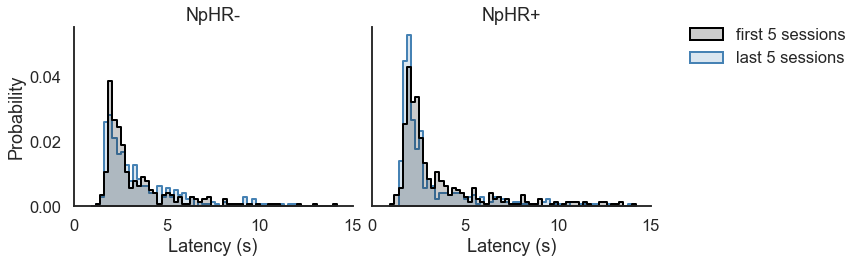

In [163]:
no_illumination = below15[below15['stim_condition']==0]
sns.set(style='white', context='talk')

g = sns.displot(kind='hist', data=no_illumination, col='group', x='latency_to_cp_entry',
                hue=no_illumination['first_last'].map({0:'first 5 sessions ', 1:'last 5 sessions '}), 
                stat='probability', col_order=['CTRL', 'NPHR'], element='step', 
                palette=['black','steelblue'], bins=60, alpha=.2, height=4, aspect=1.2, linewidth=2)

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+",xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
g._legend.set(bbox_to_anchor=(1,.75), title='')
sns.despine()

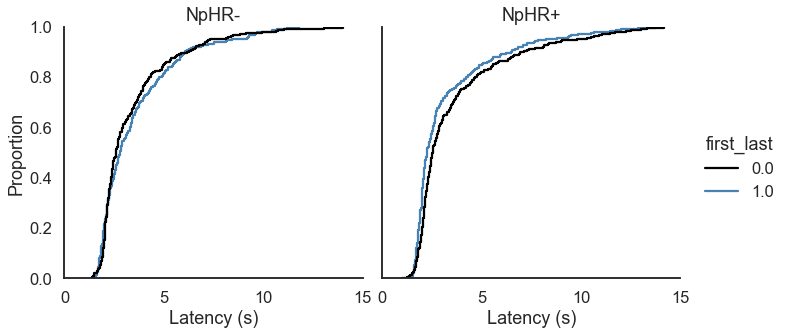

In [164]:
g = sns.displot(kind='ecdf', data=no_illumination, col='group' , x='latency_to_cp_entry',
            stat='proportion', hue='first_last', col_order=['CTRL', 'NPHR'], palette=['black','steelblue'])

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
sns.despine()

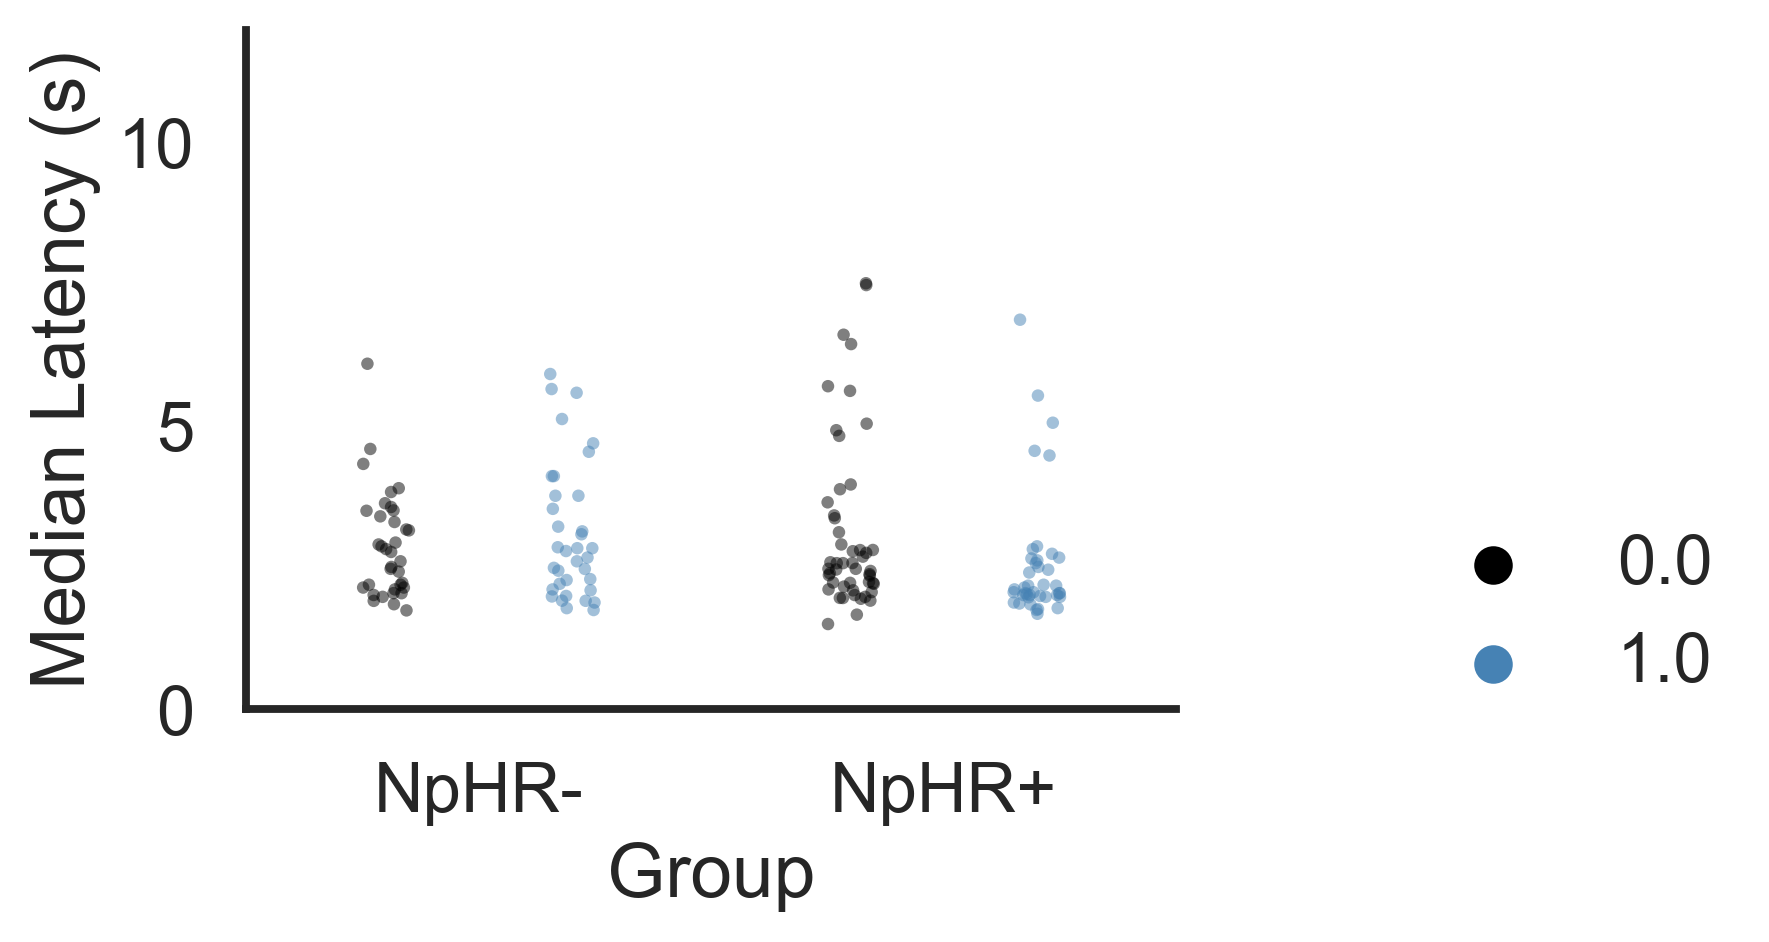

In [172]:
sns.set(style='white', context='talk')
plt.figure(figsize=(4,3),dpi=300)

g = sns.stripplot(
    data=no_illumination_medians, y='latency_to_cp_entry', hue='first_last', 
    x='group', palette=['black','steelblue'], dodge=True,
    s=3, alpha=.5)

g.set(xlabel='Group', ylabel='Median Latency (s)', xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'],
      ylim=[0,12])
plt.legend(bbox_to_anchor=(1.2,.35), title='', frameon=False)
sns.despine()
sns.despine()

## <font color = 'royalblue'> Latencies until the choice point distributions divided by outcome

In [65]:
corrects=below15[below15['outcome']==1]
nphr_corrects = corrects[corrects['group']=='NPHR']
ctrl_corrects=corrects[corrects['group']=='CTRL']

In [66]:
errors=below15[below15['outcome']==0]
nphr_errors = errors[errors['group']=='NPHR']
ctrl_errors=errors[errors['group']=='CTRL']
nphr_errors.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971
16,2019-08-09T11_26_15,NPHR1,22.0,1301.300608,T,3,0.0,NPHR,1303.369702,1304.408230,2.069094,3.107622,1.038528
24,2019-08-09T11_26_15,NPHR1,40.0,2385.598310,T,3,0.0,NPHR,2388.177114,2388.857050,2.578803,3.258739,0.679936


In [67]:
corrects.groupby(['group', 'stim_condition'])['run_nr'].count()

group  stim_condition
CTRL   0                 780
       3                 735
NPHR   0                 981
       3                 908
Name: run_nr, dtype: int64

In [68]:
errors.groupby(['group', 'stim_condition'])['run_nr'].count()

group  stim_condition
CTRL   0                 174
       3                 202
NPHR   0                 215
       3                 256
Name: run_nr, dtype: int64

### Histograms and cumulative distributions within group

<Figure size 1800x1200 with 0 Axes>

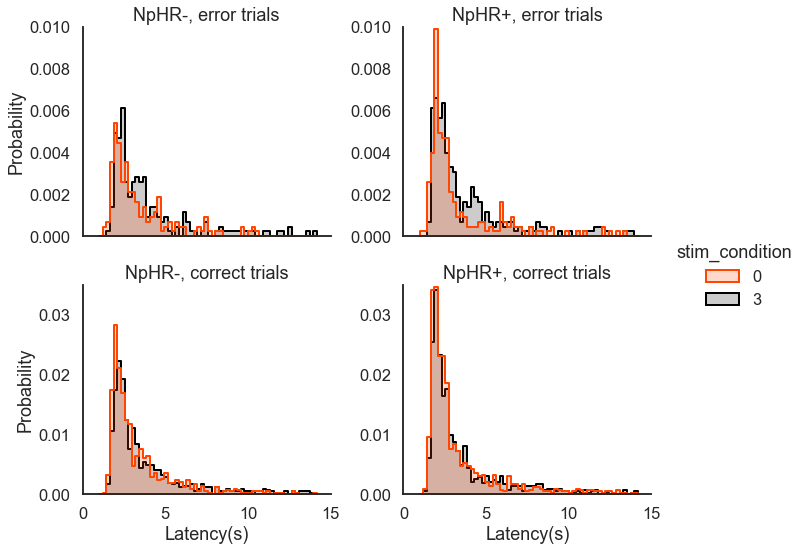

In [69]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)

g = sns.displot(
    kind='hist', data=below15, col='group', row='outcome', x='latency_to_cp_entry',
    stat='probability', hue='stim_condition', col_order=['CTRL', 'NPHR'],element='step',
    palette=['orangered','black'], bins=60, alpha=.2, height=4, aspect=1.2, facet_kws={'sharey':False}, linewidth=2
)

g.set(xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes = g.axes.flatten()
axes[0].set(title="NpHR-, error trials", ylim=[0, 0.01])
axes[1].set(title="NpHR+, error trials", ylim=[0,0.01], xlabel='')
axes[2].set(title="NpHR-, correct trials", ylim=[0,0.035])
axes[3].set(title="NpHR+, correct trials", ylim=[0,0.035])
sns.despine()

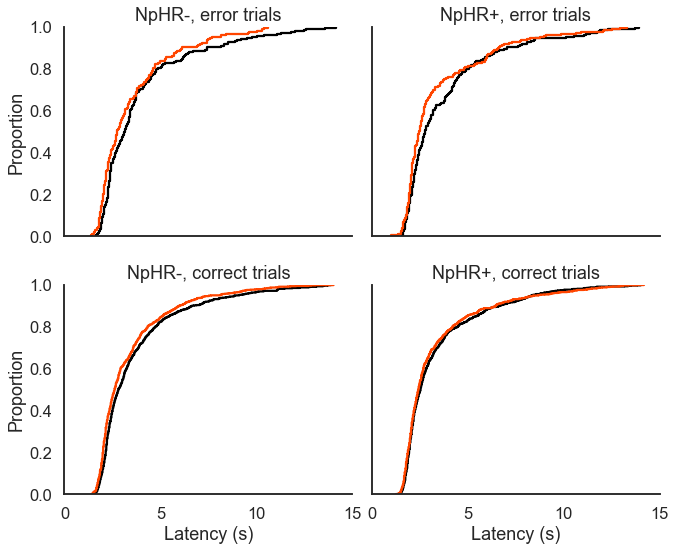

In [73]:
sns.set(style='white', context='talk')
g = sns.displot(kind='ecdf', data=below15, col='group', row='outcome', x='latency_to_cp_entry',
            stat='proportion', hue='stim_condition', col_order=['CTRL', 'NPHR'],
                palette=['orangered','black'], height=4, aspect=1.2, legend=False)

g.set(xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes = g.axes.flatten()
axes[0].set(title="NpHR-, error trials")
axes[1].set(title="NpHR+, error trials", xlabel='')
axes[2].set(title="NpHR-, correct trials")
axes[3].set(title="NpHR+, correct trials")
sns.despine()

### Inference testing on latency to choice point distributions within group

##### error trials

In [75]:
# Using the Mann-Whitney test to compare medians in the NPHR+ group
nphr_errors_no = nphr_errors[nphr_errors['stim_condition']==0]
nphr_errors_illum = nphr_errors[nphr_errors['stim_condition']==3]

u, p = mannwhitneyu(x=nphr_errors_no['latency_to_cp_entry'], y=nphr_errors_illum['latency_to_cp_entry'], 
                    alternative='two-sided')

print('NPHR+, errors, Mann-Whitney result: '+str(u)+', p-value: '+str(p))

NPHR+, errors, Mann-Whitney result: 23880.5, p-value: 0.013390223630526655


In [76]:
# Using the Mann-Whitney test to compare medians in the NPHR- group
ctrl_errors_no = ctrl_errors[ctrl_errors['stim_condition']==0]
ctrl_errors_illum = ctrl_errors[ctrl_errors['stim_condition']==3]

u, p = mannwhitneyu(x=ctrl_errors_no['latency_to_cp_entry'], y=ctrl_errors_illum['latency_to_cp_entry'], 
                    alternative='two-sided')

print('NPHR-,errors, Mann-Whitney: '+str(u)+', p-value: '+str(p))

NPHR-,errors, Mann-Whitney: 15324.0, p-value: 0.03229829738914687


##### correct trials

In [77]:
# Using the Mann-Whitney test to compare medians in the NPHR+ group
nphr_corrects_no = nphr_corrects[nphr_corrects['stim_condition']==0]
nphr_corrects_illum = nphr_corrects[nphr_corrects['stim_condition']==3]

u, p = mannwhitneyu(x=nphr_corrects_no['latency_to_cp_entry'], 
                    y=nphr_corrects_illum['latency_to_cp_entry'], alternative='two-sided')

print('NPHR+, corrects, Mann-Whitney result: '+str(u)+', p-value: '+str(p))

NPHR+, corrects, Mann-Whitney result: 423305.5, p-value: 0.062442698157786615


In [78]:
# Using the Mann-Whitney test to compare medians in the NPHR- group
ctrl_corrects_no = ctrl_corrects[ctrl_corrects['stim_condition']==0]
ctrl_corrects_illum = ctrl_corrects[ctrl_corrects['stim_condition']==3]

u, p = mannwhitneyu(x=ctrl_corrects_no['latency_to_cp_entry'], 
                    y=ctrl_corrects_illum['latency_to_cp_entry'], 
                    alternative='two-sided')

print('NPHR-, corrects, Mann-Whitney result:'+str(u)+', p-value: '+str(p))

NPHR-, corrects, Mann-Whitney result:256571.5, p-value: 0.0004089120143487925


### Histograms and cumulative distributions within condition

<Figure size 1800x1200 with 0 Axes>

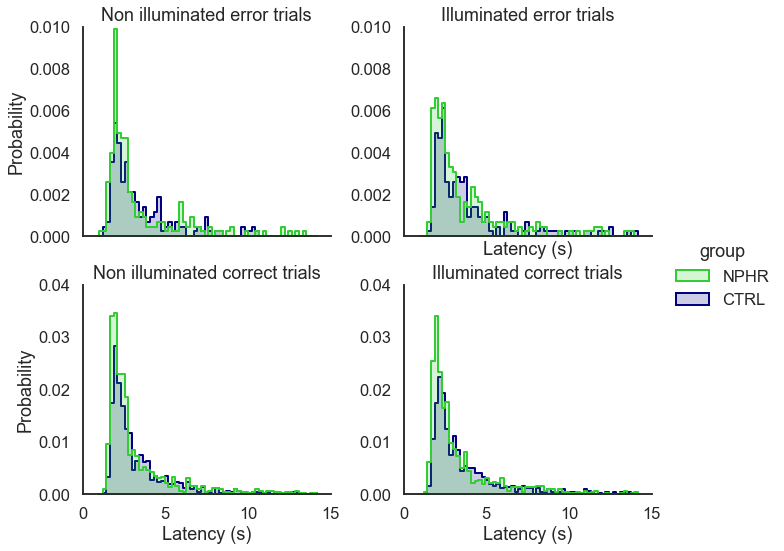

In [83]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
g = sns.displot(kind='hist', data=below15, col='stim_condition', row='outcome', x='latency_to_cp_entry',
                stat='probability', hue='group', col_order=[0, 3], element='step',
                palette=['limegreen','navy'], bins=60, alpha=.2, height=4, aspect=1.2,
                facet_kws={'sharey':False}, linewidth=2)
g.set(xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes = g.axes.flatten()
axes[0].set(title="Non illuminated error trials", ylim=[0,0.01])
axes[1].set(title="Illuminated error trials", ylim=[0,0.01])
axes[2].set(title="Non illuminated correct trials", ylim=[0,0.04])
axes[3].set(title="Illuminated correct trials", ylim=[0,0.04])
sns.despine()

<Figure size 1800x1200 with 0 Axes>

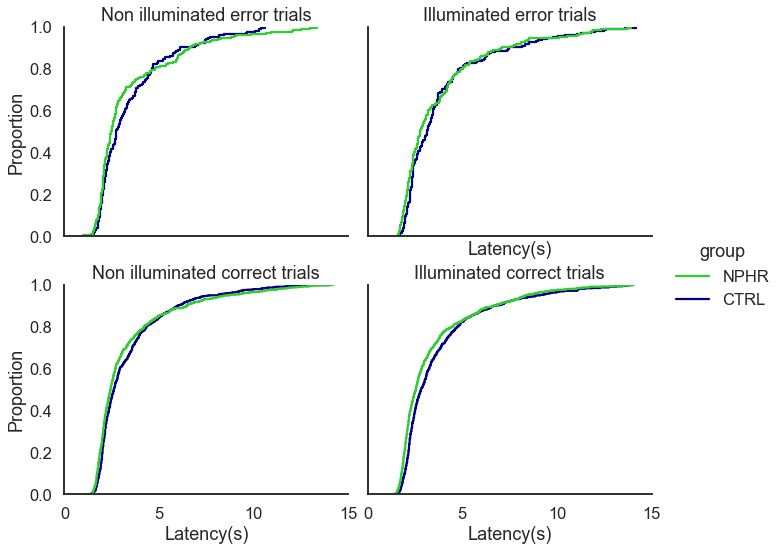

In [85]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)

#Cumulative distribution plot
g = sns.displot(
    kind='ecdf', data=below15, col='stim_condition', row='outcome', x='latency_to_cp_entry',
    stat='proportion', hue='group', col_order=[0, 3], palette=['limegreen','navy'],
    height=4, aspect=1.2
)
#Subplot specifications
g.set(xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes = g.axes.flatten()
axes[0].set(title="Non illuminated error trials")
axes[1].set(title="Illuminated error trials")
axes[2].set(title="Non illuminated correct trials")
axes[3].set(title="Illuminated correct trials")

sns.despine()

### Inference testing on latency to choice point distributions within group

##### error trials

In [86]:
nphr_errors_no = nphr_errors[nphr_errors['stim_condition']==0]
nphr_errors_illum = nphr_errors[nphr_errors['stim_condition']==3]
ctrl_errors_no = ctrl_errors[ctrl_errors['stim_condition']==0]
ctrl_errors_illum = ctrl_errors[ctrl_errors['stim_condition']==3]

In [87]:
# Using the Mann-Whitney test to compare medians for error trials in the No illumination condition
u, p = mannwhitneyu(x=nphr_errors_no['latency_to_cp_entry'], y=ctrl_errors_no['latency_to_cp_entry'], 
                    alternative='two-sided')

print('Non illuminated errors, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

Non illuminated errors, Mann-Whitney result, test stat: 16842.5, p-value: 0.09128313641071062


In [88]:
# Using the Mann-Whitney test to compare medians for error trials in the Illumination condition
u, p = mannwhitneyu(x=ctrl_errors_illum['latency_to_cp_entry'], y=nphr_errors_illum['latency_to_cp_entry'], 
                    alternative='two-sided')
print('Illuminated errors, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

Illuminated errors, Mann-Whitney result, test stat: 28080.5, p-value: 0.1138018215374487


##### correct trials

In [102]:
nphr_corrects_no = nphr_corrects[nphr_corrects['stim_condition']==0]
nphr_corrects_illum = nphr_corrects[nphr_corrects['stim_condition']==3]
ctrl_corrects_no = ctrl_corrects[ctrl_corrects['stim_condition']==0]
ctrl_corrects_illum = ctrl_corrects[ctrl_corrects['stim_condition']==3]

In [90]:
# Using the Mann-Whitney test to compare medians for error trials in the Illumination condition
u, p = mannwhitneyu(x=ctrl_corrects_illum['latency_to_cp_entry'], 
                    y=nphr_corrects_illum['latency_to_cp_entry'], 
                    alternative='two-sided')
print('Illuminated corrects, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

Illuminated corrects, Mann-Whitney result, test stat: 381665.0, p-value: 5.242311877508463e-07


In [91]:
# Using the Mann-Whitney test to compare medians for error trials in the No illumination condition
u, p = mannwhitneyu(x=nphr_corrects_no['latency_to_cp_entry'], 
                    y=ctrl_corrects_no['latency_to_cp_entry'], 
                    alternative='two-sided')

print('Non illuminated corrects, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

Non illuminated corrects, Mann-Whitney result, test stat: 347652.5, p-value: 0.0009806066467049227


### Is median latency correlated with performance in sessions?

In [ ]:
below_15.drop(['first_last'], axis=1, inplace=True)

In [173]:
%run data_prep_functions.ipynb
perfs_and_median_lats = below_15.groupby(['group','session']).apply(calc_performance_and_median_latency_in_group)

NameError: name 'below_15' is not defined

In [ ]:
perfs_and_median_lats.drop(['session', 'run_nr', 'start_timestamp','run_type', 'stim_condition', 
                            'group', 'cp_entry_timestamp', 'cp_entry_timestamp','cp_exit_timestamp', 
                            'latency_to_cp_exit', 'latency_to_cp_entry'], axis=1, inplace=True)

In [ ]:
perfs_and_median_lats.reset_index(inplace=True)
perfs_and_median_lats

In [ ]:
sns.relplot(kind='scatter', data=perfs_and_median_lats, 
            col='group',
            x='median_latency', y='performance', hue='group')
sns.despine()

In [ ]:
%run data_prep_functions.ipynb
perfs_and_median_lats = below_15.groupby(['group','session','stim_condition']).apply(
    calc_performance_and_median_latency_in_group)

In [ ]:
perfs_and_median_lats.drop(['session', 'run_nr', 'start_timestamp','run_type', 'stim_condition', 
                            'group', 'cp_entry_timestamp', 'cp_entry_timestamp','cp_exit_timestamp', 
                            'latency_to_cp_exit', 'latency_to_cp_entry'], axis=1, inplace=True)

In [ ]:
perfs_and_median_lats.reset_index(inplace=True)
perfs_and_median_lats.head(10)

In [ ]:
plt.figure(dpi=300)
illum = perfs_and_median_lats[perfs_and_median_lats['stim_condition']=='3']
g= sns.relplot( kind='scatter', data=illum, 
                col='group', row='stim_condition', x='median_latency',
                y='performance', color='orangered', s=40,height=6)

ax = g.axes.flatten()
ax[0].set(xlabel='Session Median Latency (s)', ylabel='Session Performance (%)')
ax[1].set(xlabel='Session Median Latency (s)', ylabel='Session Performance (%)')
sns.despine()

In [ ]:
plt.figure(dpi=300)
no_illum = perfs_and_median_lats[perfs_and_median_lats['stim_condition']=='0']
g= sns.relplot( kind='scatter', data=no_illum, 
                col='group', row='stim_condition', x='median_latency',
                y='performance', color='black', s=40,height=6)

ax = g.axes.flatten()
ax[0].set(xlabel='Session Median Latency (s)', ylabel='Session Performance (%)', xlim=[0,10], ylim=[30,105])
ax[1].set(xlabel='Session Median Latency (s)', ylabel='Session Performance (%)', xlim=[0,10], ylim=[30,105])
sns.despine()